In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from functools import partial
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from moviepy.editor import ImageSequenceClip
import sys
import pendulum

# Visualisation of a double pendulum

In [4]:
x0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
t_demo = np.linspace(0, 100, num=1000, dtype=np.float32)
demo_trajectory = pendulum.solve_analytical(x0, t_demo, g=9.8)

In [5]:
L1, L2 = 1, 1
theta1, theta2 = demo_trajectory[:, 0], demo_trajectory[:, 1]
cart_coords = pendulum.radial2cartesian(theta1, theta2, L1, L2)

0/1
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4

Moviepy - Done !
Moviepy - video ready __temp__.mp4


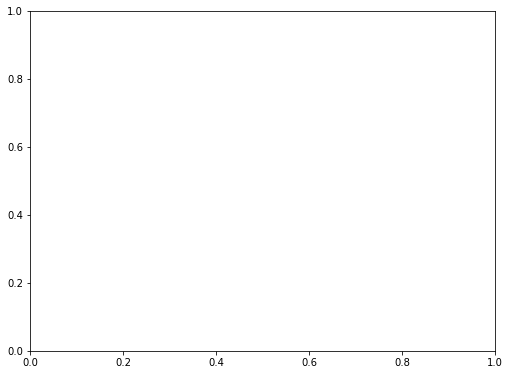

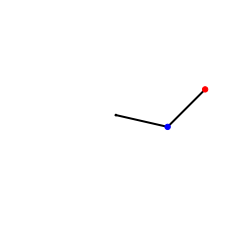

In [6]:
fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

images = []
di = 1
N = 1
for i in range(0, N, di):
    print("{}/{}".format(i // di, N // di), end='\n' if i//di%20==0 else ' ')
    pendulum.make_plot(i, cart_coords, L1, L2)
    images.append( pendulum.fig2image(fig) )

ImageSequenceClip(images, fps=25.).ipython_display()

# Prepare a noisy observed trajectory

In [7]:
t = np.linspace(0, 10, num=5, dtype=np.float32)
def sample_trajectories_by_gs(key, gs, noise_std=0.5):
    # odeint is bugged with vmap, probably becouse of the control flow to maintain tolerance
    true_trajectories = jnp.array([pendulum.solve_analytical(x0, t, g=g) for g in gs])
    return true_trajectories + jax.random.normal(key, true_trajectories.shape, true_trajectories.dtype)*noise_std

In [8]:
rng = jax.random.PRNGKey(41231)
rng, subkey = jax.random.split(rng)
observed_trajectory = sample_trajectories_by_gs(subkey, [9.8])

In [9]:
observed_trajectory = np.array(observed_trajectory)

In [10]:
observed_trajectory.shape

(1, 5, 4)

# What if we didn't know the likelihood?

# L-GSO

https://arxiv.org/abs/2002.04632

In [11]:
import torch

In [12]:
class Simulator:
    def __init__(self, rng_key):
        self.rng_key = rng_key
    
    def simulate(self, gs):
        self.rng_key, subkey = jax.random.split(self.rng_key)
        trajectory = sample_trajectories_by_gs(subkey, jax.numpy.array(gs.ravel(), dtype=jax.numpy.float32))
        return torch.tensor(np.array(trajectory).reshape((gs.shape[0], -1)))

In [13]:
rng, subkey = jax.random.split(rng)
simulator = Simulator(subkey)

In [14]:
from gan_model import GANModel
from experience_replay import ExperienceReplay
from optimizer import TorchOptimizer

In [15]:
class DoublePendulumLossModel:
    """
    Just a class that implements loss function between GAN surrogate output and real output
    """
    def __init__(self, ground_truth_data):
        self.ground_truth_data = ground_truth_data.view(1, -1)
        
    def loss(self, y, conditions):
        return ((self.ground_truth_data - y)**2).mean()
    
y_model = DoublePendulumLossModel(torch.tensor(observed_trajectory).float())

In [16]:
simulator.simulate(np.array([5.]))

tensor([[ 0.9438,  1.9554, -0.5243,  0.1454, -1.8628, -1.4289,  0.7781,  1.7277,
          1.0496,  4.2183, -1.6455,  4.2909,  0.2393, 14.4571,  1.1370, -1.4946,
         -1.3830,  9.8013,  0.7803, -0.7391]])

In [17]:
(simulator.simulate(np.array([5.])) - observed_trajectory.reshape(-1)).pow(2).mean()

tensor(19.8121)

In [18]:
(simulator.simulate(np.array([3.])) - observed_trajectory.reshape(-1)).pow(2).mean()

tensor(15.8944)

In [19]:
(simulator.simulate(np.array([9.8])) - observed_trajectory.reshape(-1)).pow(2).mean()

tensor(0.3326)

In [20]:
(simulator.simulate(np.array([20.8])) - observed_trajectory.reshape(-1)).pow(2).mean()

tensor(30.7193)

In [21]:
device = "cpu"

model_config = {
    'task': "CRAMER", #"REVERSED_KL", #"CRAMER", #"CRAMER", #"REVERSED_KL",  # 'WASSERSTEIN', # WASSERSTEIN, REVERSED_KL
    'y_dim': 20,
    'x_dim': 0,
    'psi_dim': 1,
    'noise_dim': 150,
    'lr': 1e-4 * 8,
    'batch_size': 512,
    'epochs': 15,
    'iters_discriminator': 1,
    'iters_generator': 1,
    'instance_noise_std': 0.01,
    'burn_in_period': None,
    'averaging_coeff': 0.,
    'dis_output_dim': 256,
    'grad_penalty': True,
    'attention_net_size': None,
    'gp_reg_coeff': 10,
    'device': device
    # 'predict_risk': False
}

In [22]:
exp_replay = ExperienceReplay(
    psi_dim=model_config['psi_dim'],
    y_dim=model_config['y_dim'],
    x_dim=model_config['x_dim'],
    device=device
)

In [23]:
def generate_local_data(simulator, current_psi, step=0.1, n_samples=5):
    """
    Sampler of new points around current parameters
    """
    psis = np.random.uniform(low=-1., high=1., size=(n_samples, current_psi.shape[0]))
    psis = current_psi[np.newaxis] + step * psis
    data = simulator.simulate(psis.reshape(-1))
    return data, psis.float()

In [24]:
# area for training surrogate
step_data_gen = 1.

# points to sample at each epoch
n_samples = 10

# initial psi
current_psi=torch.tensor([14.])

In [25]:
# optimizer that we are going to re-use
optimizer_config = {
    'lr': 0.1,
    'num_repetitions': 10000,
    'max_iters': 1,
    'torch_model': 'Adam',
}

In [26]:
# sample new data
output, condition = generate_local_data(simulator, current_psi, step=step_data_gen, n_samples=n_samples)

In [27]:
# look up in experience replay
output_exp_replay, condition_exp_replay = exp_replay.extract(psi=current_psi, step=step_data_gen)
exp_replay.add(y=output, condition=condition)
output = torch.cat([output, output_exp_replay], dim=0)
condition = torch.cat([condition, condition_exp_replay], dim=0)

In [28]:
# if not reusing model
# then at each epoch re-initialize and re-fit GAN
model = GANModel(**model_config, y_model=y_model).to(device)
model.fit(output, condition=condition)
model.eval()

GANModel(
  (_generator): Generator(
    (fc1): Linear(in_features=151, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (fc3): Linear(in_features=100, out_features=20, bias=True)
    (fc4): Linear(in_features=100, out_features=100, bias=True)
  )
  (_discriminator): Discriminator(
    (fc1): Linear(in_features=21, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (fc3): Linear(in_features=100, out_features=100, bias=True)
    (fc4): Linear(in_features=100, out_features=256, bias=True)
  )
)

In [29]:
previous_psi = current_psi.clone()
optimizer = TorchOptimizer(oracle=model, x=current_psi, **optimizer_config)

optimizer.update(oracle=model, x=current_psi)
current_psi, status, history = optimizer.optimize()

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.1
    weight_decay: 0
)


In [30]:
previous_psi, current_psi

(tensor([14.]), tensor([14.1000]))

## Stack everything together

In [31]:
from tqdm.notebook import tqdm

for epochs in tqdm(range(200)):    
    # sample new data
    output, condition = generate_local_data(simulator, current_psi, step=step_data_gen, n_samples=n_samples)

    # look up in experience replay
    output_exp_replay, condition_exp_replay = exp_replay.extract(psi=current_psi, step=step_data_gen)
    exp_replay.add(y=output, condition=condition)
    output = torch.cat([output, output_exp_replay], dim=0)
    condition = torch.cat([condition, condition_exp_replay], dim=0)

    # if not reusing model
    # then at each epoch re-initialize and re-fit GAN
    model = GANModel(**model_config, y_model=y_model).to(device)
    model.fit(output, condition=condition)
    model.eval()

    # optimize psi with surrogate
    previous_psi = current_psi.clone()
    optimizer.update(oracle=model, x=current_psi)
    current_psi, status, history = optimizer.optimize()
    if epochs % 10 == 0:
        print(
            f"Current optima: {current_psi.item()}, Current MSE: {history['func'][0]}, Dataset size: {condition.shape[0]}"
        )
        print()

  0%|          | 0/200 [00:00<?, ?it/s]

Current optima: 14.20009708404541, Current MSE: 16.629741668701172, Dataset size: 20

Current optima: 13.93106460571289, Current MSE: 16.8713436126709, Dataset size: 111

Current optima: 13.213568687438965, Current MSE: 15.240385055541992, Dataset size: 160

Current optima: 12.339691162109375, Current MSE: 11.717662811279297, Dataset size: 132

Current optima: 11.600752830505371, Current MSE: 9.6381196975708, Dataset size: 127

Current optima: 11.020171165466309, Current MSE: 8.338957786560059, Dataset size: 153

Current optima: 10.278650283813477, Current MSE: 6.138432025909424, Dataset size: 155

Current optima: 9.288348197937012, Current MSE: 0.7008216977119446, Dataset size: 116

Current optima: 9.143068313598633, Current MSE: 1.9731818437576294, Dataset size: 181

Current optima: 9.855711936950684, Current MSE: 1.267384648323059, Dataset size: 320

Current optima: 9.718302726745605, Current MSE: 1.1556415557861328, Dataset size: 412

Current optima: 9.581842422485352, Current MSE: